# Benchmark of loading dataset approaches in TensorFlow

This notebook benchmarks four different approaches to input a dataset to fit a model using TensorFlow. While it is possible to do it with a custom generator, the `tf.data` API offers possibilities which may be more confortable and even more efficient. Here the tested approaches:

* **a)** Using `.from_tensor_slices()`
* **b)** Using `.from_generator()`
* **c)** Using `.flow_from_directory()`
* **d)** Using `.tfrecords`

Let's start by importing the required packages and the configuration stored in `parameters.ini`.

In [3]:
import os
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import wandb
os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join(os.getcwd(), "DatasetLoadingBenchmark.ipynb")
import utils
import configparser

config = configparser.ConfigParser()
config.read('parameters.ini')
N = int(config['DEFAULT']['n'])
HEIGHT = int(config['DEFAULT']['height'])
WIDTH = int(config['DEFAULT']['width'])
BATCH_SIZE = int(config['DEFAULT']['batch_size'])
BUFFER_SIZE = int(config['DEFAULT']['buffer_size'])
EPOCHS = int(config['DEFAULT']['epochs'])
STEPS = N // BATCH_SIZE

DATA_PATH = os.path.join(os.getcwd(), "Data")

### Download toy data

To benchmark the dataset creation approaches, we need a task to solve, a toy dataset and a model to train. We will solve a segmentation task on the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)) with the UNet-like model provided in the [Image Segmentation TensorFlow tutorial](https://www.tensorflow.org/tutorials/images/segmentation). The next line of code downloads the dataset and structures it as follows in the determined `project` directory indicated with the variable `DATA_PATH`, defined in `parameters.ini`. It may take about 5 minutes.
```
{DATA_PATH}
|
└───images
│   |   image001.png
│   |   image002.png
│   |   ...
|
└───masks
    │   mask001.png
    │   mask002.png
    |   ...
```

In [2]:
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

utils.download_data(DATA_PATH)

Data is already in indicated path: ..\Data


### Create TensorFlow datasets with different approaches

##### **a)** Using `.from_tensor_slices()`

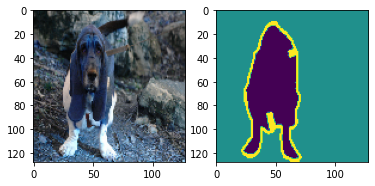

In [4]:
from DatasetLoadingApproaches import using_from_tensor_slices
dataset_a = using_from_tensor_slices.get_dataset(DATA_PATH, BATCH_SIZE, BUFFER_SIZE)

for batch in dataset_a.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1); plt.imshow(sample_image)
    plt.subplot(1,2,2); plt.imshow(sample_mask)

##### **b)** Using `.from_generator()`

In [108]:
from DatasetLoadingApproaches import using_from_generator
from time import time

start = time()
images_paths, masks_paths = using_from_generator.get_data_paths(DATA_PATH)
semipreloaded_images = using_from_generator.load_samples(images_paths, "images", preprocess=False, verbose=1)
semipreloaded_masks = using_from_generator.load_samples(masks_paths, "masks", preprocess=False, verbose=1)
print(f"- Done ({time() - start:.2f} seconds)")

100%|██████████| 7384/7384 [00:04<00:00, 1784.42it/s]

- Done (25.50 seconds)


100%|██████████| 7384/7384 [00:05<00:00, 1253.57it/s]


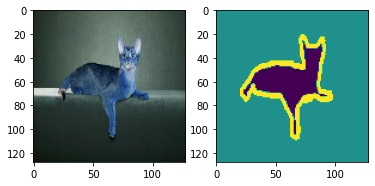

In [7]:
from DatasetLoadingApproaches import using_from_generator

# From paths
generator_b_from_paths = using_from_generator.get_generator_from_paths(DATA_PATH, BATCH_SIZE)
dataset_b_from_paths = using_from_generator.get_dataset_from_paths(DATA_PATH, BATCH_SIZE)

# From preloaded data (kind of a manual cache). It should be faster because data is already in the RAM during training and does not need to be loaded at every epoch
images_paths, masks_paths = using_from_generator.get_data_paths(DATA_PATH)
preloaded_images = using_from_generator.load_samples(images_paths, "images", verbose=1)
preloaded_masks = using_from_generator.load_samples(masks_paths, "masks", verbose=1)
generator_b_from_preloaded_data = using_from_generator.get_generator_from_data(preloaded_images, preloaded_masks, BATCH_SIZE)
dataset_b_from_preloaded_data = using_from_generator.get_dataset_from_data(preloaded_images, preloaded_masks, BATCH_SIZE)

# Form semi-preloaded data, i.e., in uint8 while we really need it in float32 for the fit(). The dataset requires a map().
# This is smart because uint8 take much less space so they may fit into the RAM.
images_paths, masks_paths = using_from_generator.get_data_paths(DATA_PATH)
semipreloaded_images = using_from_generator.load_samples(images_paths, "images", preprocess=False, verbose=1)
semipreloaded_masks = using_from_generator.load_samples(masks_paths, "masks", preprocess=False, verbose=1)
generator_b_semipreloaded = using_from_generator.get_generator_from_preloaded_data(semipreloaded_images, semipreloaded_masks, BATCH_SIZE, semipreloaded=True)
dataset_b_semipreloaded = using_from_generator.get_dataset_from_preloaded_data(semipreloaded_images, semipreloaded_masks, BATCH_SIZE, semipreloaded=True)

for batch in dataset_b_from_paths.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1); plt.imshow(sample_image)
    plt.subplot(1,2,2); plt.imshow(sample_mask)

##### **c)** Using `.flow_from_directory()`

For this approach, we need to structure out data in subdirectories.

In [5]:
utils.structure_data_in_subdirectories(DATA_PATH)

Data is already in paths: ..\directory_images, ..\directory_masks


Create dataset

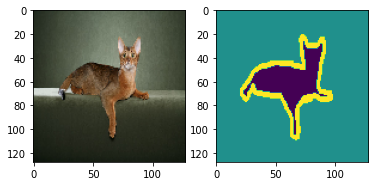

In [11]:
from DatasetLoadingApproaches import using_flow_from_directory

directory_images_path = os.path.join(DATA_PATH, "directory_images")
directory_masks_path = os.path.join(DATA_PATH, "directory_masks")
generator_c = using_flow_from_directory.get_generator(directory_images_path, directory_masks_path, BATCH_SIZE)
dataset_c = using_flow_from_directory.get_dataset(directory_images_path, directory_masks_path, BATCH_SIZE)

for batch in dataset_c.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1)
    plt.imshow(sample_image)
    plt.subplot(1,2,2)
    plt.imshow(sample_mask)

##### **d)** Using `.tfrecords`

Create TFRECORDS files

In [104]:
from DatasetLoadingApproaches import tfrecords_creation

MAX_FILES = 15

tfrecords_path = os.path.join(DATA_PATH, "TFRecords")
if os.path.isdir(tfrecords_path):
    print(f"TFRECORDS files are already in path: ..\{os.path.basename(tfrecords_path)}")
else:
    if not os.path.isdir(tfrecords_path):
        os.mkdir(tfrecords_path)
    tfrecords_creation.dynamic_write_images_to_tfr(DATA_PATH, MAX_FILES, tfrecords_path, filename="animals_float32", preprocess=True)

TFRECORDS files are already in path: ..\TFRecords


Create dataset

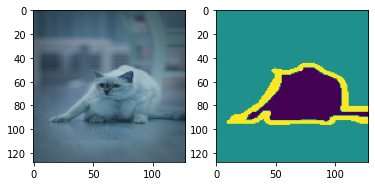

In [2]:
from DatasetLoadingApproaches import using_tfrecords

tfrecords_path = os.path.join(DATA_PATH, "TFRecords")
dataset_d_float = using_tfrecords.get_dataset(tfrecords_path, "animals_float32*.tfrecords", BATCH_SIZE, BUFFER_SIZE)
dataset_d_uint = using_tfrecords.get_dataset(tfrecords_path, "animals_uint8*.tfrecords", BATCH_SIZE, BUFFER_SIZE, mapping=using_tfrecords.map_from_uint_to_float)

for batch in dataset_d_uint.take(1):
    sample_image = batch[0][0]
    sample_mask = batch[1][0]
    plt.subplot(1,2,1)
    plt.imshow(sample_image)
    plt.subplot(1,2,2)
    plt.imshow(sample_mask)

### Benchmark training performance

Define model

In [5]:
site_packages_path = f"{sys.prefix}/lib/site-packages"
if "tensorflow_examples" not in os.listdir(site_packages_path):
    subprocess.check_call(["pip", "install", "git+https://github.com/tensorflow/examples.git"])

from segmentation_model import unet_model
model = unet_model(output_channels=3)

Segmentation Models: using `tf.keras` framework.


Train model with different dataset creation approaches

In [9]:
WANDB_ENTITY_NAME = "boadagu"
WANDB_PROJECT_NAME = "DatasetLoadingBenchmark"

datasets = [dataset_a, generator_b_from_paths, dataset_b_from_paths, generator_b_from_preloaded_data, dataset_b_from_preloaded_data, generator_b_semipreloaded, dataset_b_semipreloaded, dataset_c, dataset_d_float, dataset_d_uint]
run_names = ["Using .from_tensor_slices()", "Using simple generator", "Using .from_generator()", "Using simple generator with preloaded data", "Using .from_generator() with preloaded data", "Using simple generator with semipreloaded data", "Using .from_generator() with semipreloaded data", "Using .flow_from_directory()", "Using .tfrecords"]

for i,(run_name,dataset) in enumerate(zip(run_names, datasets)):
                print(run_name)
                wandb.init(project=WANDB_PROJECT_NAME, entity=WANDB_ENTITY_NAME, name=run_name + f" [{EPOCHS} epochs]")
                model.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS, callbacks=[utils.MonitorCallback()])
                wandb.finish()

Using .from_generator() with semipreloaded data


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: Network error (ConnectionError), entering retry loop.


Epoch 1/100
115/923 [==>...........................] - ETA: 29s - loss: 0.3834 - accuracy: 0.8543

wandb: Network error resolved after 0:00:16.639843, resuming normal operation.


923/923 [==============================] - 34s 37ms/step - loss: 0.3298 - accuracy: 0.8751
Epoch 2/100
923/923 [==============================] - 32s 35ms/step - loss: 0.2843 - accuracy: 0.8919
Epoch 3/100
923/923 [==============================] - 32s 34ms/step - loss: 0.2671 - accuracy: 0.8982
Epoch 4/100
923/923 [==============================] - 32s 34ms/step - loss: 0.2569 - accuracy: 0.9016
Epoch 5/100
923/923 [==============================] - 32s 34ms/step - loss: 0.2489 - accuracy: 0.9047
Epoch 6/100
923/923 [==============================] - 33s 35ms/step - loss: 0.2387 - accuracy: 0.9081
Epoch 7/100
923/923 [==============================] - 33s 35ms/step - loss: 0.2306 - accuracy: 0.9108
Epoch 8/100
923/923 [==============================] - 33s 36ms/step - loss: 0.2228 - accuracy: 0.9137
Epoch 9/100
923/923 [==============================] - 33s 36ms/step - loss: 0.2135 - accuracy: 0.9170
Epoch 10/100
923/923 [==============================] - 34s 37ms/step - loss: 0.2062 

RAM (%),▁▂▃▄▅▆▇█▇▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
RAM (MB),▁▂▃▄▅▆▇█▇▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
VRAM (MB) from smi,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
VRAM (MB) from tf,▃▁▂▅▂▅▅▅▂▄▄▅▂▇▄▂▅▆▆█▄▂▇▁▄▅▄▄▅▅▁▇▂▄█▂▁▁▂▃
RAM (%),52.7
RAM (MB),17131.39062
VRAM (MB) from smi,5843.71405
VRAM (MB) from tf,67.11963


### Results

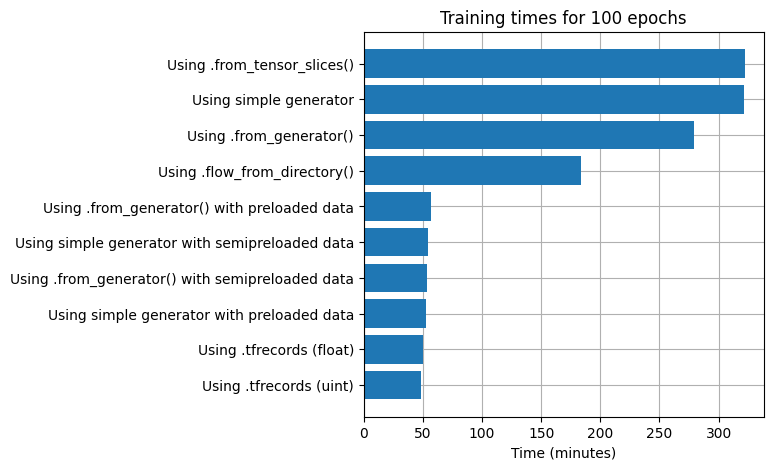

TOP TRAINING TIMES:
0.49 minutes / epoch - Using .tfrecords (uint)
0.50 minutes / epoch - Using .tfrecords (float)
0.52 minutes / epoch - Using simple generator with preloaded data
0.53 minutes / epoch - Using .from_generator() with semipreloaded data
0.54 minutes / epoch - Using simple generator with semipreloaded data
0.57 minutes / epoch - Using .from_generator() with preloaded data
1.84 minutes / epoch - Using .flow_from_directory()
2.80 minutes / epoch - Using .from_generator()
3.22 minutes / epoch - Using simple generator
3.22 minutes / epoch - Using .from_tensor_slices()


In [140]:
# Import runtimes from W&B 
api = wandb.Api()
runs_dict = {}
for run in api.runs(path="boadagu/DatasetLoadingBenchmark", filters={"display_name": {"$regex": ".*\[100 epochs\]"}}, order="+summary_metrics.runtime"):
    runs_dict[run.name] = run.summary.get('_wandb')['runtime']

# Preprocess runtimes for plotting
run_times_in_seconds = [runs_dict[run_name + " [100 epochs]"] for run_name in run_names]
order_idxs = np.argsort(run_times_in_seconds)[::-1]
ordered_run_names = np.array(run_names)[order_idxs]
ordered_run_times_in_minutes = np.array(run_times_in_seconds)[order_idxs] / 60
ordered_run_times_in_hours = np.array(run_times_in_seconds)[order_idxs] / 60 / 60

# Visualize
SAVE_PLOT = True
fig, ax = plt.subplots(figsize=(8,5))
y_pos = np.arange(len(ordered_run_names))
ax.barh(y_pos, ordered_run_times_in_minutes, align='center')
ax.set_yticks(y_pos, labels=ordered_run_names)
ax.invert_yaxis()
ax.set_xlabel('Time (minutes)')
ax.set_title(f'Training times for {EPOCHS} epochs')
ax.set_axisbelow(True)
ax.grid()
plt.gcf().subplots_adjust(left=0.4)
plt.show()

if SAVE_PLOT:
    fig.savefig(os.path.join(os.getcwd(), "TrainingTimes.png"), dpi=fig.dpi)

print(f"TOP TRAINING TIMES:")
for run_name, run_time in zip(ordered_run_names[::-1], ordered_run_times_in_minutes[::-1]):
    print(f"{run_time/EPOCHS:.2f} minutes / epoch -", run_name)

### Conclusions

Using **TFRECORDS** is the fastest approach (~ 30 seconds / epoch) followed by the **preloaded and semipreloaded datasets**, which do not seem to show any significant difference between them. These methods require a priori computation expense: for the used animals dataset (7384 samples resized to 128x128), TFRECORDS files are created in ~ 27 seconds and data is preloaded in ~ 25 seconds. The difference is minimal. However, if the training run with a particular dataset is planned to be executed multiple times, using TFRECORDS is a better choice because they only need to be created once, against preloading the data, which needs to be done everytime. Moreover, this preloading will take GPU compute time if being run on a cloud service, which is more expensive than CPU compute time. The drawbacks of TFRECORDS are that they take storage space and are less transparent, because they have been binarized. 